In [5]:
import math

import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as dist
from scipy.optimize import minimize
from scipy.stats import norm

# Your known samples (measured values)
rand_samples= torch.tensor([1.2, 2.7])  # Explicitly defining the values

# Known ground truth function values for training (what you've observed)
xaxis = torch.linspace(0, 3, 1000)
ground_truth = torch.sin(2*xaxis) + torch.cos(5*xaxis)

# Let's pretend you only have these observations
train_x = rand_samples
train_y = torch.sin(2*train_x) + torch.cos(5*train_x)  # Ground truth at the observed points

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = torch.tensor(1e-4)


class SurrogateModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y,likelihood):
        super(SurrogateModel, self).__init__(train_x,train_y,likelihood)
        self.mean = gpytorch.means.ConstantMean()

        #use ScaleKernel() to introduce variance hyperparameter
        self.covar = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean = self.mean(x)
        covar = self.covar(x)
        return gpytorch.distributions.MultivariateNormal(mean,covar)


def train(model, train_x, train_y, training_iter,  lr = .001):
    
    # Find optimal model hyperparameters
    model.train() #this doesn't actually train it just sets the surrogate into training mode
    model.likelihood.train()

    #this initializes Adam to optimize variance and lengthscale of RBF kernel to minimize
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

    for i in range(training_iter):
        
        # Zero gradients from previous iteration
        optimizer.zero_grad()

       # Outputs (size of train_x) number multivariate distributions
        output = model(train_x)
        
        # Measures how well the GP fits the observed data
        loss = -mll(output, train_y) 
        loss.backward()
        
        #if i%10==0 or i == training_iter -1:
            #print(f'Iter {i+1}/{training_iter} - Loss: {loss.item():.3f}   '
                  #f'Lengthscale: {model.covar.base_kernel.lengthscale.item():.3f}   '
                  #f'Variance (outputscale): {model.covar.outputscale.item():.3f}   ')

        optimizer.step()

def predict(model, xaxis):
    """
    Make predictions with the trained GP model at new points.
    
    :param model: The trained Gaussian Process model.
    :param xaxis: Tensor of input points at which to make predictions.
    :return: mean and standard deviation of the GP at the given points.
    """
    model.eval()  # Set the model in evaluation mode
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Make predictions
        observed_pred = model(xaxis)
        mean = observed_pred.mean
        stddev = observed_pred.stddev
    return mean,stddev


'''Acquisition Functions'''
def poi(model,xaxis,train_y, epsilon):

    best_value = torch.max(train_y)
    mean, stdev = predict(model,xaxis)

    z = (mean - best_value - epsilon) / (stdev + 1e-9)
    PI = dist.Normal(0,1).cdf(z)

    return xaxis[torch.argmax(PI)]


def ei(model,xaxis, train_y, epsilon):

    best_value = torch.max(train_y)
    mean, stdev = predict(model, xaxis)

    z = (mean - best_value - epsilon) / (stdev + 1e-9)  # Avoid division by zero
    normal = dist.Normal(0, 1)

    expected_improvement = (mean - best_value - epsilon) * normal.cdf(z) + stdev * normal.log_prob(z).exp()
    return xaxis[torch.argmax(expected_improvement)]

def ucb(model, xaxis, train_y, epsilon):
    mean, stdev = predict(model, xaxis)
    ucb_value = mean + epsilon * stdev
    return xaxis[torch.argmax(ucb_value)]

def thompson_sampling(model, xaxis, train_y, epsilon):
    mean, stdev = predict(model, xaxis)
    samples = mean + stdev * torch.randn_like(mean)
    return xaxis[torch.argmax(samples)]

"Bayesian Optimization loop for any number of iterations, along with graphing"
def bayesian_optimization(model,xaxis,train_x,train_y, acquisition_function, epsilon, n_iter):

    for iteration in range(n_iter):
        next_sample = acquisition_function(model, xaxis, train_y, epsilon)
        next_y = torch.sin(2*next_sample) + torch.cos(5*next_sample)

        train_x = torch.cat([train_x, next_sample.unsqueeze(0)])
        train_y = torch.cat([train_y, next_y.unsqueeze(0)])

        #add new sample to model
        model = SurrogateModel(train_x, train_y, likelihood)

        #retrain model and update mean and stdev
        train(model, train_x, train_y, training_iter=50, lr=0.001)
        mean, stddev = predict(model, xaxis)


        # Plot the ground truth
        plt.plot(xaxis.numpy(), ground_truth.numpy(), 'k', label='Ground Truth')

        # Plot the predicted mean
        plt.plot(xaxis.numpy(), mean.numpy(), 'b', label='Predicted Mean')

        # Plot the predicted uncertainty (mean ± stddev)
        plt.fill_between(xaxis.numpy(), (mean + 1.96 * stddev).numpy(), (mean - 1.96 * stddev).numpy(), alpha=0.3, color='blue', label='Confidence Interval (95%)')

        # Plot the training points
        plt.scatter(train_x.numpy(), train_y.numpy(), color='r', zorder=10, label='Training Data')

        # Update title with iteration number
        plt.title(f'Gaussian Process Regression Iteration: {iteration+1}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()

        # Show the plot
        plt.show()

In [25]:
def optimize_acquisition(acquisition_function, xaxis, ground_truth, n_runs=100, 
                        epsilon_range=(0.01, 2.0), n_epsilons=10, n_iter=5, tolerance=0.05):
    """
    Optimize the epsilon value for an acquisition function based on the number of samples taken.
    
    :param acquisition_function: The acquisition function to test (e.g., ei, poi).
    :param xaxis: Tensor of input points for predictions.
    :param ground_truth: Tensor of the ground truth function values.
    :param n_runs: Number of Bayesian optimization runs per epsilon (default: 100).
    :param epsilon_range: Tuple of (min_epsilon, max_epsilon) to test.
    :param n_epsilons: Number of epsilon values to evaluate in the range.
    :param n_iter: Maximum number of iterations per Bayesian optimization run.
    :param tolerance: How close to the true maximum is considered "found".
    :return: Optimal epsilon value and statistics.
    """
    true_max = torch.max(ground_truth)  # True maximum of the ground truth function
    epsilon_values = np.linspace(epsilon_range[0], epsilon_range[1], n_epsilons)
    samples_to_max = np.zeros((n_epsilons, n_runs))  # Store number of samples needed for each run
    
    for eps_idx, epsilon in enumerate(epsilon_values):
        print(f"Testing epsilon: {epsilon:.3f}")
        for run in range(n_runs):
            # Randomize initial points for each run
            rand_samples = torch.rand(2) * 3  # Two random points in [0, 3]
            train_x = rand_samples
            train_y = torch.sin(2 * train_x) + torch.cos(5 * train_x)

            # Initialize the model
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            likelihood.noise = torch.tensor(1e-4)
            model = SurrogateModel(train_x, train_y, likelihood)
            train(model, train_x, train_y, training_iter=50, lr=0.001)

            # Run Bayesian optimization
            for iteration in range(n_iter):
                next_sample = acquisition_function(model, xaxis, train_y, epsilon)
                next_y = torch.sin(2 * next_sample) + torch.cos(5 * next_sample)

                # Update training data
                train_x = torch.cat([train_x, next_sample.unsqueeze(0)])
                train_y = torch.cat([train_y, next_y.unsqueeze(0)])
                model.set_train_data(train_x, train_y, strict=False)
                train(model, train_x, train_y, training_iter=50, lr=0.001)

                # Check if we've reached the maximum
                current_max = torch.max(train_y)
                if torch.abs(current_max - true_max) <= tolerance:
                    samples_to_max[eps_idx, run] = train_x.size(0)  # Total samples taken
                    break
                elif iteration == n_iter - 1:
                    # If max iterations reached without finding the maximum, assign a high value
                    samples_to_max[eps_idx, run] = train_x.size(0) + 1  # Penalty

        # Calculate average samples for this epsilon
        avg_samples = np.mean(samples_to_max[eps_idx])
        print(f"Epsilon {epsilon:.3f} - Avg samples to max: {avg_samples:.2f}")

    # Find the epsilon with the minimum average samples
    avg_samples_per_epsilon = np.mean(samples_to_max, axis=1)
    best_epsilon_idx = np.argmin(avg_samples_per_epsilon)
    best_epsilon = epsilon_values[best_epsilon_idx]
    best_avg_samples = avg_samples_per_epsilon[best_epsilon_idx]

    print(f"\nOptimal epsilon: {best_epsilon:.3f}")
    print(f"Average samples to reach maximum: {best_avg_samples:.2f}")

    # Optional: Plotting results
    plt.plot(epsilon_values, avg_samples_per_epsilon, 'b-', label='Avg Samples to Max')
    plt.axvline(best_epsilon, color='r', linestyle='--', label=f'Optimal Epsilon: {best_epsilon:.3f}')
    plt.xlabel('Epsilon')
    plt.ylabel('Average Samples to Reach Maximum')
    plt.title('Epsilon Optimization for Acquisition Function')
    plt.legend()
    plt.show()

In [24]:
def optimize_acquisition(acquisition_function, xaxis, ground_truth, n_runs=100, 
                        epsilon_range=(0.01, 2.0), n_epsilons=10, n_iter=5, tolerance=0.05):
    """
    Optimize the epsilon value for an acquisition function based on the number of samples taken.
    
    :param acquisition_function: The acquisition function to test (e.g., ei, poi).
    :param xaxis: Tensor of input points for predictions.
    :param ground_truth: Tensor of the ground truth function values.
    :param n_runs: Number of Bayesian optimization runs per epsilon (default: 100).
    :param epsilon_range: Tuple of (min_epsilon, max_epsilon) to test.
    :param n_epsilons: Number of epsilon values to evaluate in the range.
    :param n_iter: Maximum number of iterations per Bayesian optimization run.
    :param tolerance: How close to the true maximum is considered "found".
    :return: Optimal epsilon value and statistics.
    """
    true_max = torch.max(ground_truth)  # True maximum of the ground truth function
    epsilon_values = np.linspace(epsilon_range[0], epsilon_range[1], n_epsilons)
    samples_to_max = np.zeros((n_epsilons, n_runs))  # Store number of samples needed for each run
    
    for eps_idx, epsilon in enumerate(epsilon_values):
        print(f"Testing epsilon: {epsilon:.3f}")
        for run in range(n_runs):
            # Randomize initial points for each run
            rand_samples = torch.rand(2) * 3  # Two random points in [0, 3]
            train_x = rand_samples
            train_y = torch.sin(2 * train_x) + torch.cos(5 * train_x)

            # Initialize the model
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            likelihood.noise = torch.tensor(1e-4)
            model = SurrogateModel(train_x, train_y, likelihood)
            train(model, train_x, train_y, training_iter=50, lr=0.001)

            # Run Bayesian optimization
            for iteration in range(n_iter):
                next_sample = acquisition_function(model, xaxis, train_y, epsilon)
                next_y = torch.sin(2 * next_sample) + torch.cos(5 * next_sample)

                # Update training data
                train_x = torch.cat([train_x, next_sample.unsqueeze(0)])
                train_y = torch.cat([train_y, next_y.unsqueeze(0)])
                model.set_train_data(train_x, train_y, strict=False)
                train(model, train_x, train_y, training_iter=50, lr=0.001)

                # Check if we've reached the maximum
                current_max = torch.max(train_y)
                if torch.abs(current_max - true_max) <= tolerance:
                    samples_to_max[eps_idx, run] = train_x.size(0)  # Total samples taken
                    break
                elif iteration == n_iter - 1:
                    # If max iterations reached without finding the maximum, assign a high value
                    samples_to_max[eps_idx, run] = train_x.size(0) + 1  # Penalty

        # Calculate average samples for this epsilon
        avg_samples = np.mean(samples_to_max[eps_idx])
        print(f"Epsilon {epsilon:.3f} - Avg samples to max: {avg_samples:.2f}")

    # Find the epsilon with the minimum average samples
    avg_samples_per_epsilon = np.mean(samples_to_max, axis=1)
    best_epsilon_idx = np.argmin(avg_samples_per_epsilon)
    best_epsilon = epsilon_values[best_epsilon_idx]
    best_avg_samples = avg_samples_per_epsilon[best_epsilon_idx]

    print(f"\nOptimal epsilon: {best_epsilon:.3f}")
    print(f"Average samples to reach maximum: {best_avg_samples:.2f}")

    # Optional: Plotting results
    plt.plot(epsilon_values, avg_samples_per_epsilon, 'b-', label='Avg Samples to Max')
    plt.axvline(best_epsilon, color='r', linestyle='--', label=f'Optimal Epsilon: {best_epsilon:.3f}')
    plt.xlabel('Epsilon')
    plt.ylabel('Average Samples to Reach Maximum')
    plt.title('Epsilon Optimization for Acquisition Function')
    plt.legend()
    plt.show()

    return best_epsilon, avg_samples_per_epsilon

# Example usage (add this at the end of your script):
if __name__ == "__main__":
    # Initialize basic components
    xaxis = torch.linspace(0, 3, 1000)
    ground_truth = torch.sin(2 * xaxis) + torch.cos(5 * xaxis)

    # Test with Expected Improvement (ei)
    best_eps, stats = optimize_acquisition(
        acquisition_function=ei,
        xaxis=xaxis,
        ground_truth=ground_truth,
        n_runs=100,
        epsilon_range=(0.05, .06),
        n_epsilons=10,
        n_iter=5,
        tolerance=0.05
    )

Testing epsilon: 0.050


KeyboardInterrupt: 

In [ ]:
rando = torch.rand(2) * 3  # Two random points in [0, 3]
print(rando)

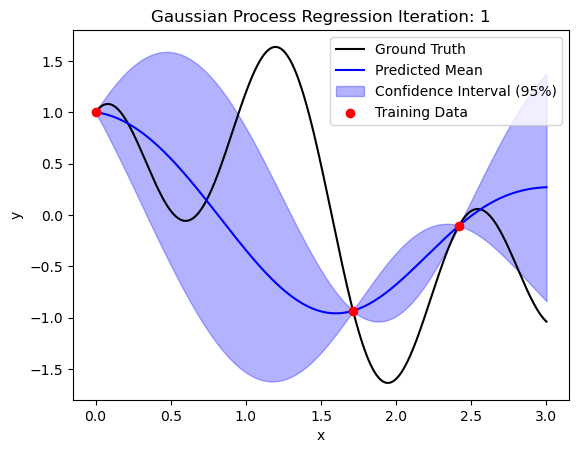

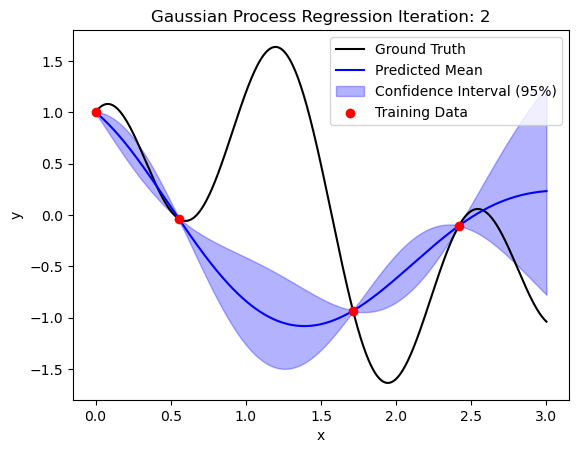

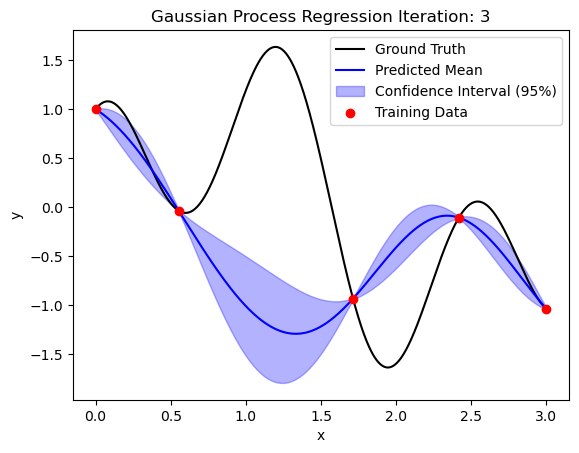

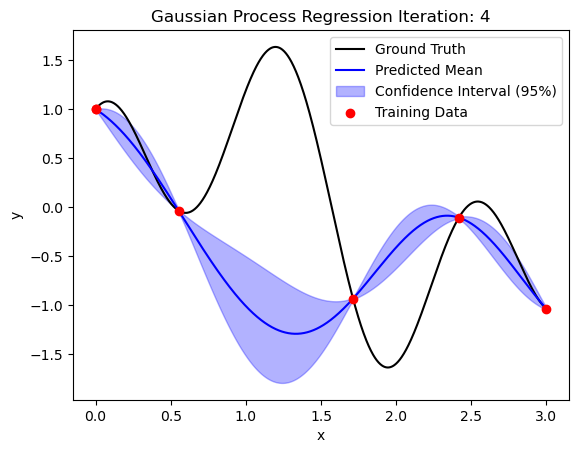

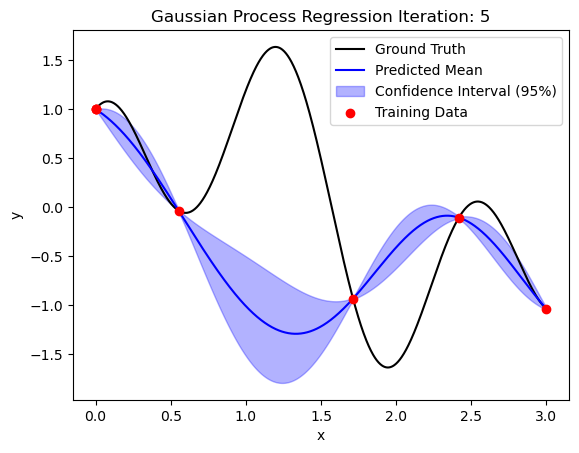

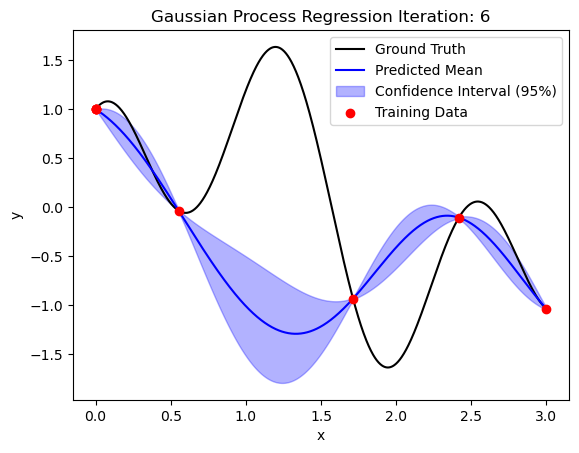

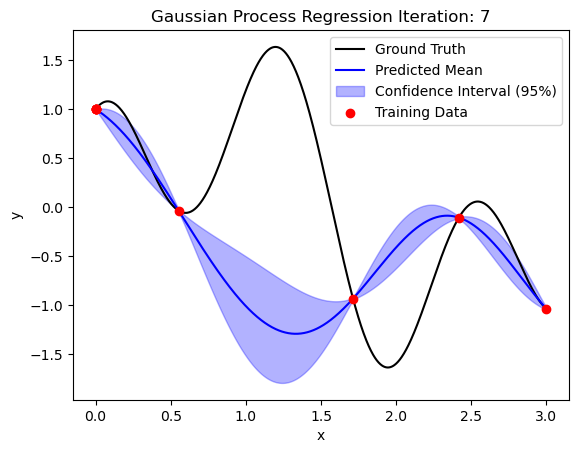

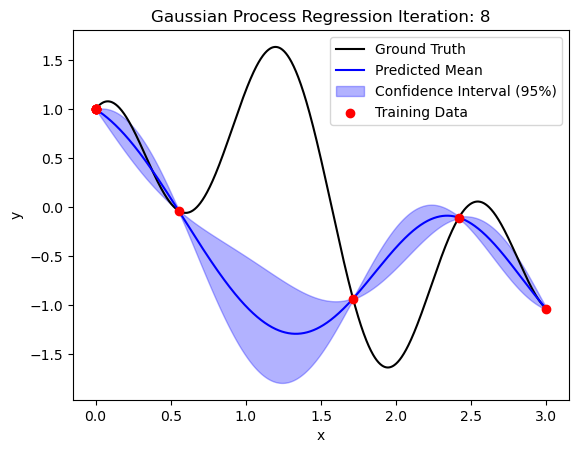

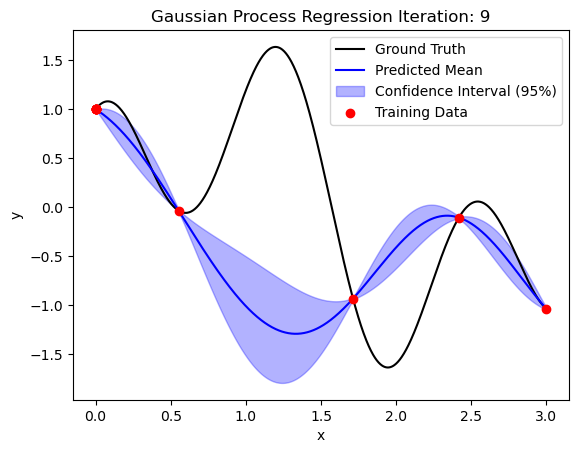

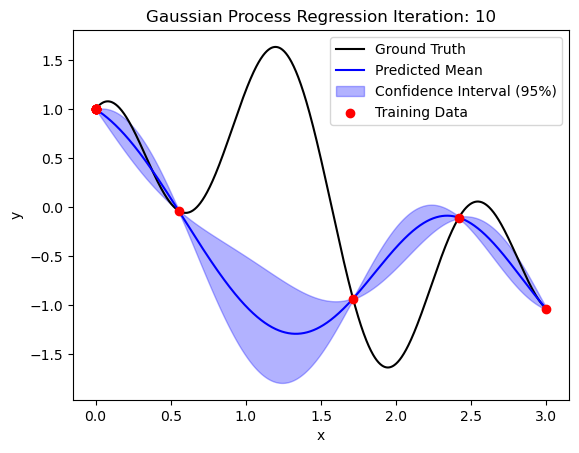

In [67]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = torch.tensor(1e-4)
model = SurrogateModel(train_x, train_y, likelihood)


bayesian_optimization(model, xaxis,train_x,train_y, poi, 1, 10)

In [ ]:
rand_samples= torch.tensor([0, 2.7])  # Explicitly defining the values

# Known ground truth function values for training (what you've observed)
xaxis = torch.linspace(0, 3, 1000)
ground_truth = torch.sin(2*xaxis) + torch.cos(5*xaxis)

# Let's pretend you only have these observations
train_x = rand_samples
train_y = torch.sin(2*train_x) + torch.cos(5*train_x)  # Ground truth at the observed points

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = torch.tensor(1e-4)

model2 = SurrogateModel(train_x, train_y, likelihood)

In [ ]:
rand_samples= torch.tensor([1,3])  # Explicitly defining the values

# Known ground truth function values for training (what you've observed)
xaxis = torch.linspace(0, 3, 1000)
ground_truth = torch.sin(2*xaxis) + torch.cos(5*xaxis)

# Let's pretend you only have these observations
train_x = rand_samples
train_y = torch.sin(2*train_x) + torch.cos(5*train_x)  # Ground truth at the observed points

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = torch.tensor(1e-4)

model_eitest = SurrogateModel(train_x, train_y, likelihood)

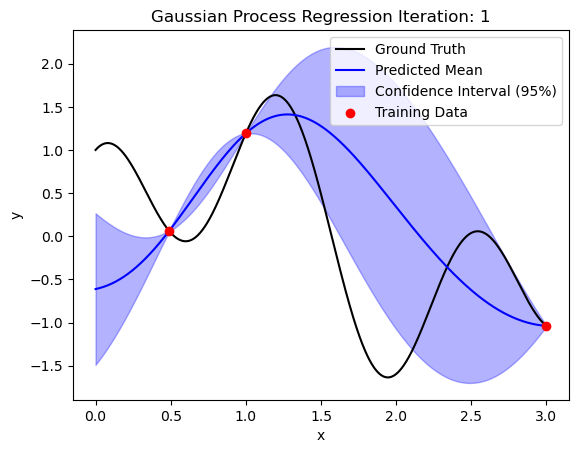

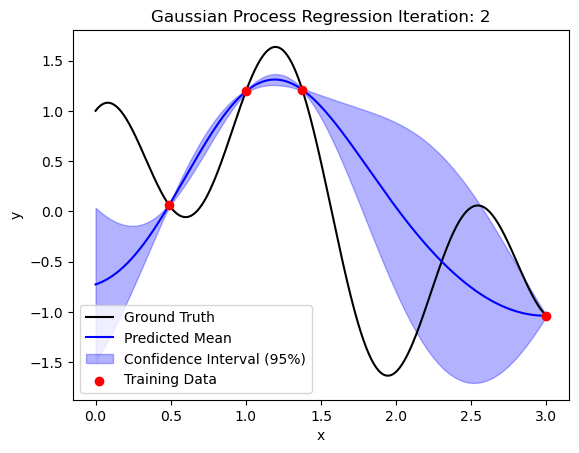

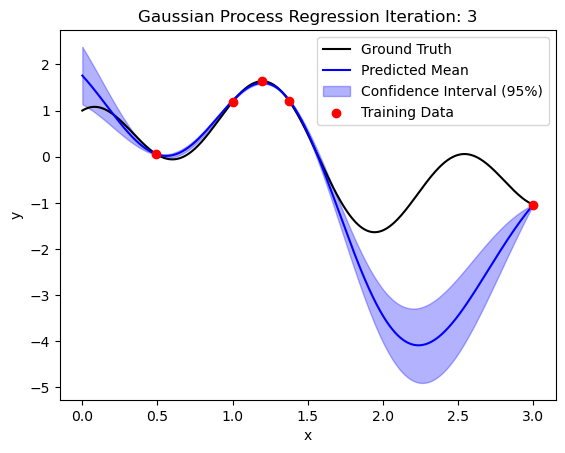

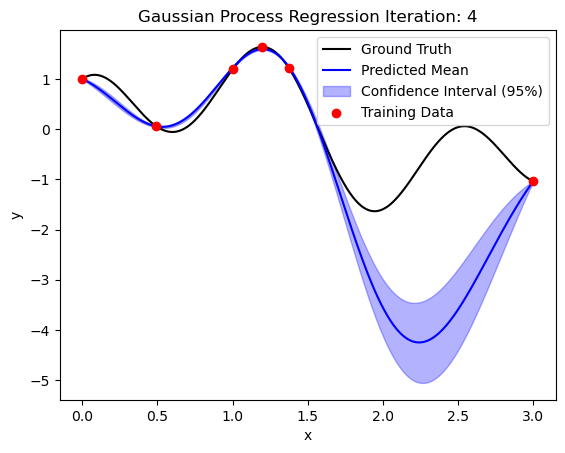

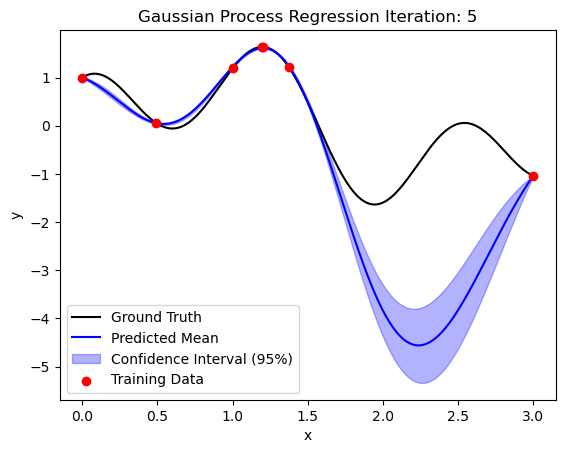

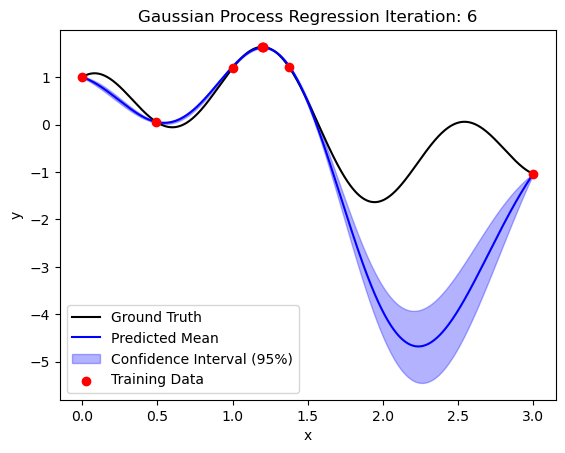

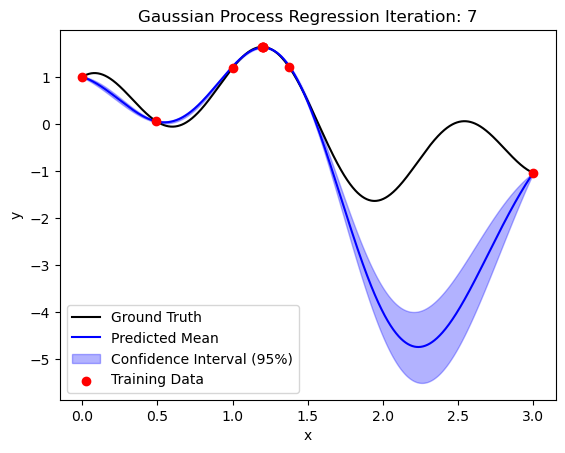

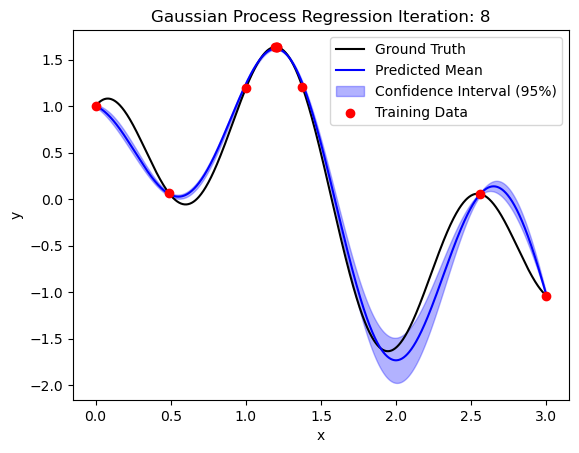

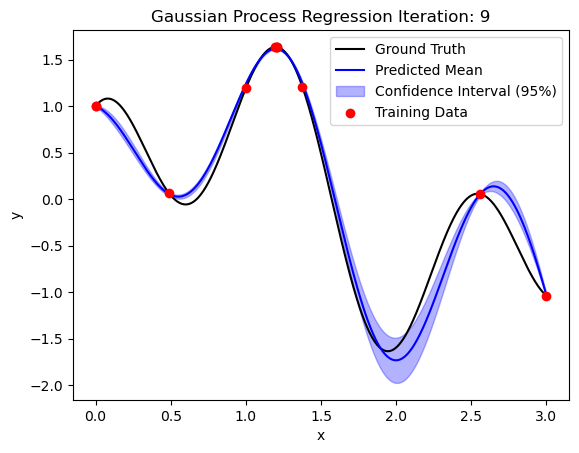

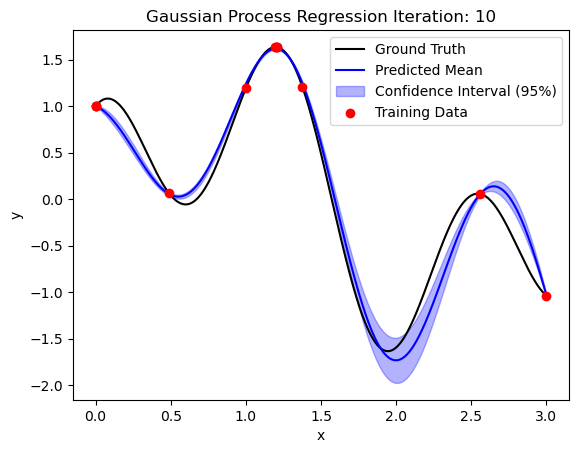

In [ ]:
bayesian_optimization(model_eitest,xaxis,train_x,train_y, ei, .058, 10)

In [ ]:
rand_samples= torch.tensor([2.5,3])  # Explicitly defining the values

# Known ground truth function values for training (what you've observed)
xaxis = torch.linspace(0, 3, 1000)
ground_truth = torch.sin(2*xaxis) + torch.cos(5*xaxis)

# Let's pretend you only have these observations
train_x = rand_samples
train_y = torch.sin(2*train_x) + torch.cos(5*train_x)  # Ground truth at the observed points

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = torch.tensor(1e-4)

model3 = SurrogateModel(train_x, train_y, likelihood)

Testing epsilon: 0.030
Epsilon 0.030 - Avg samples to max: 7.10
Testing epsilon: 0.032
Epsilon 0.032 - Avg samples to max: 6.69
Testing epsilon: 0.034
Epsilon 0.034 - Avg samples to max: 6.61
Testing epsilon: 0.037
Epsilon 0.037 - Avg samples to max: 6.86
Testing epsilon: 0.039
Epsilon 0.039 - Avg samples to max: 6.81
Testing epsilon: 0.041
Epsilon 0.041 - Avg samples to max: 6.82
Testing epsilon: 0.043
Epsilon 0.043 - Avg samples to max: 6.48
Testing epsilon: 0.046
Epsilon 0.046 - Avg samples to max: 6.60
Testing epsilon: 0.048
Epsilon 0.048 - Avg samples to max: 6.41
Testing epsilon: 0.050
Epsilon 0.050 - Avg samples to max: 6.89

Optimal epsilon: 0.048
Average samples to reach maximum: 6.41


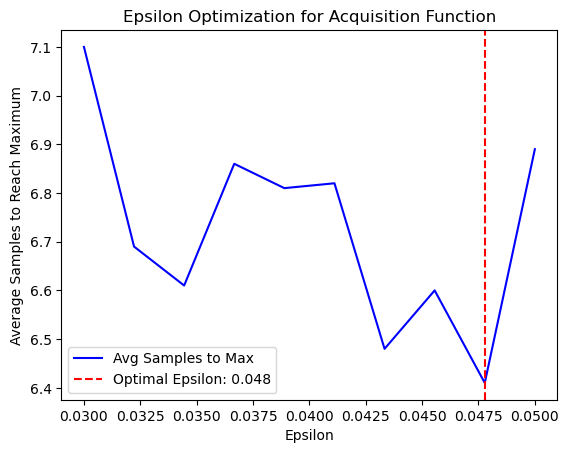

In [ ]:
"""Optimizing POI epsilon"""


    # Initialize basic components
xaxis = torch.linspace(0, 3, 1000)
ground_truth = torch.sin(2 * xaxis) + torch.cos(5 * xaxis)

# Test with Expected Improvement (ei)
best_eps, stats = optimize_acquisition(
        acquisition_function=poi,
        xaxis=xaxis,
        ground_truth=ground_truth,
        n_runs=100,
        epsilon_range=(.03,.05),
        n_epsilons=10,
        n_iter=5,
        tolerance=0.03
    )

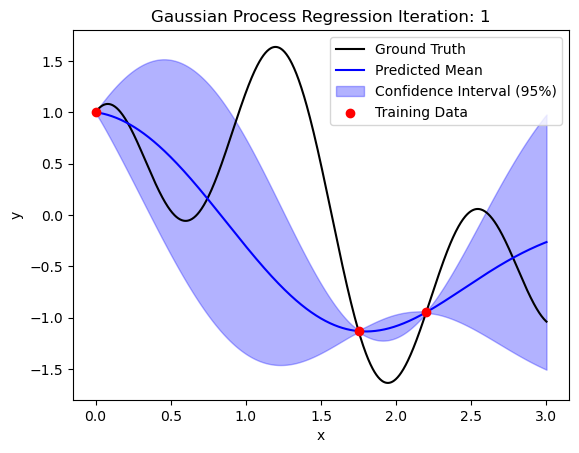

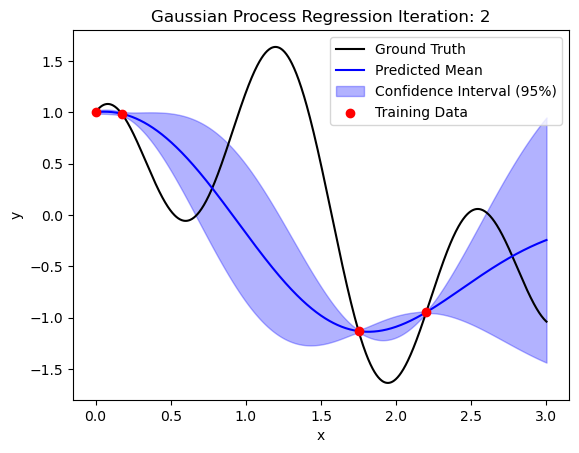

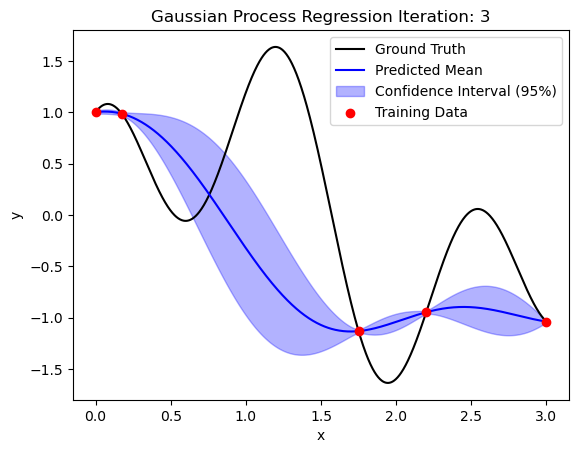

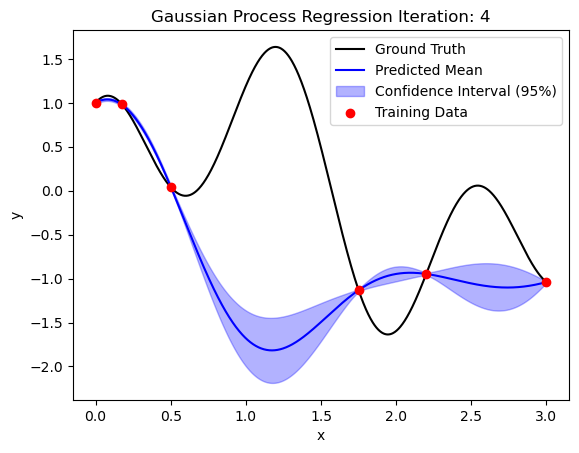

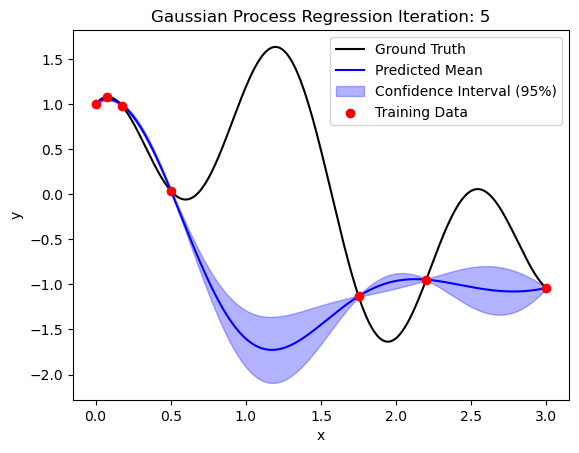

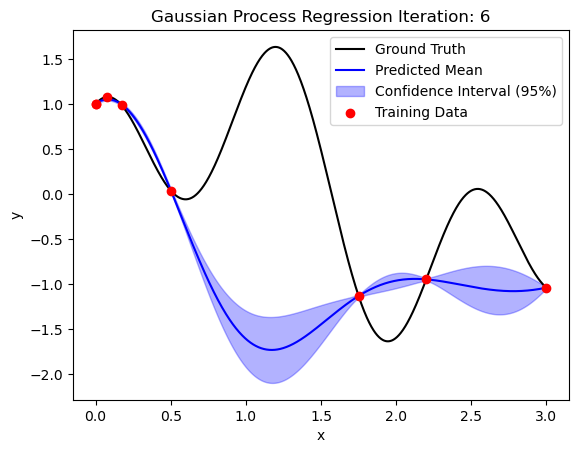

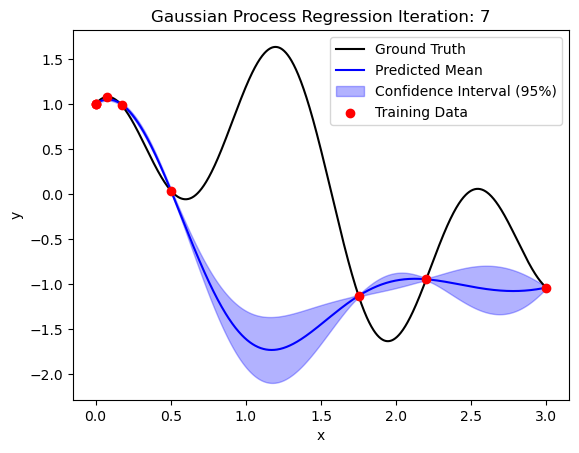

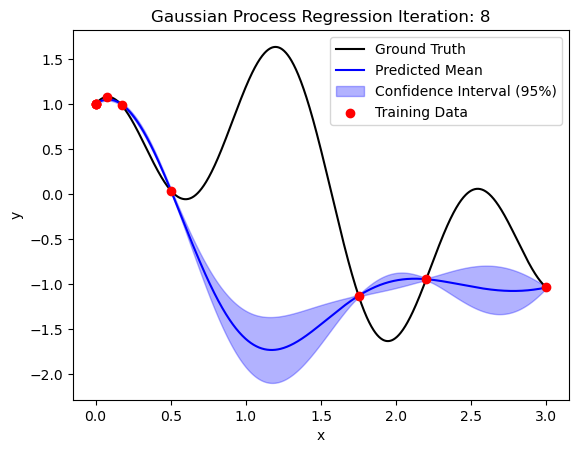

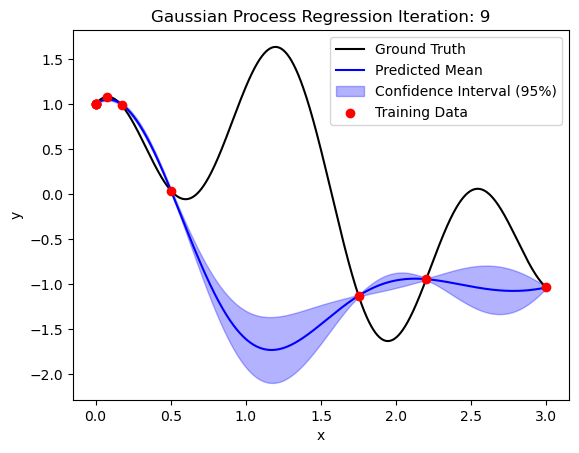

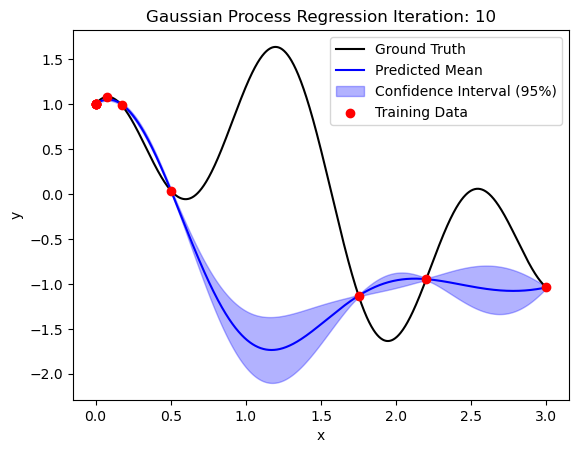

In [ ]:
rand_samples= torch.tensor([1.75,2.2])  # Explicitly defining the values

# Known ground truth function values for training (what you've observed)
xaxis = torch.linspace(0, 3, 1000)
ground_truth = torch.sin(2*xaxis) + torch.cos(5*xaxis)

# Let's pretend you only have these observations
train_x = rand_samples
train_y = torch.sin(2*train_x) + torch.cos(5*train_x)  # Ground truth at the observed points

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = torch.tensor(1e-4)

model3 = SurrogateModel(train_x, train_y, likelihood)

bayesian_optimization(model3,xaxis,train_x,train_y, poi, .0475, 10)

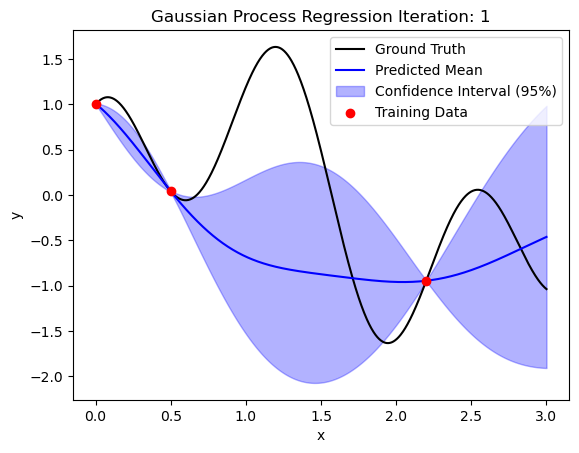

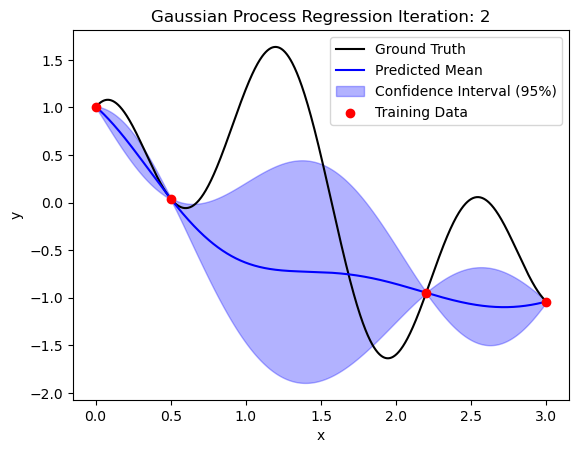

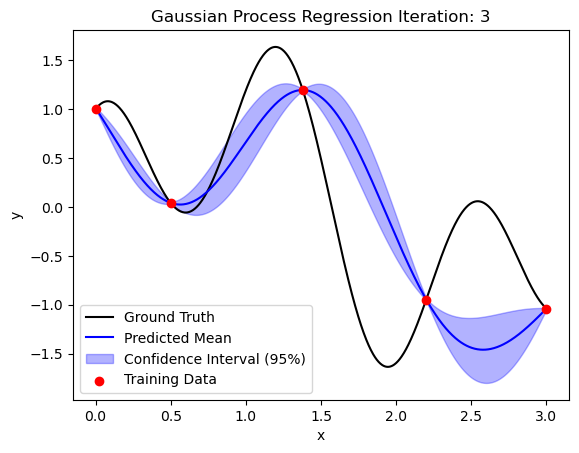

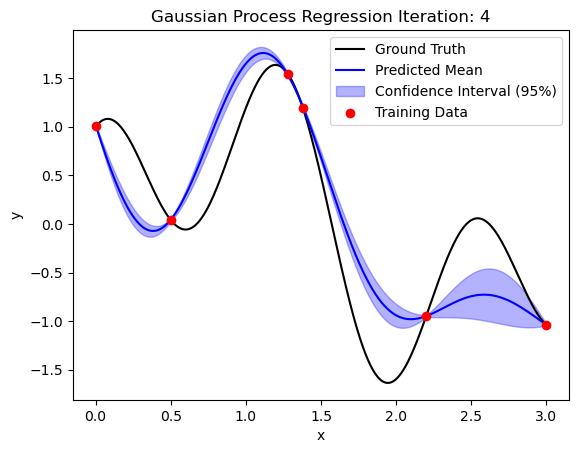

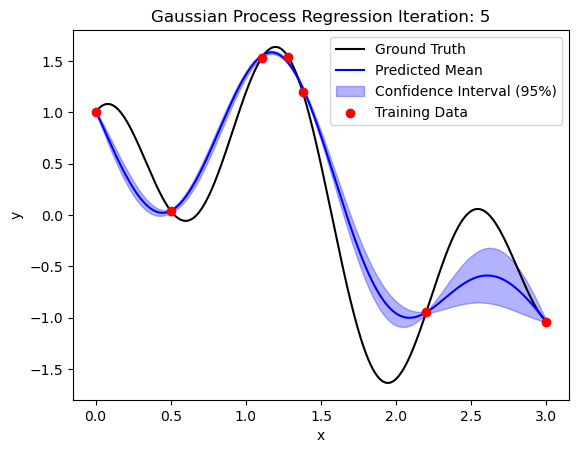

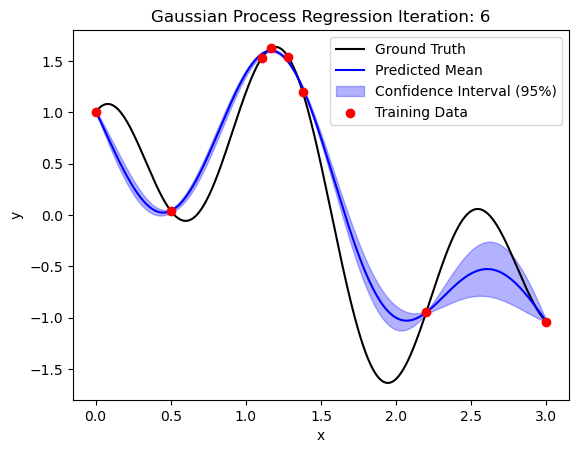

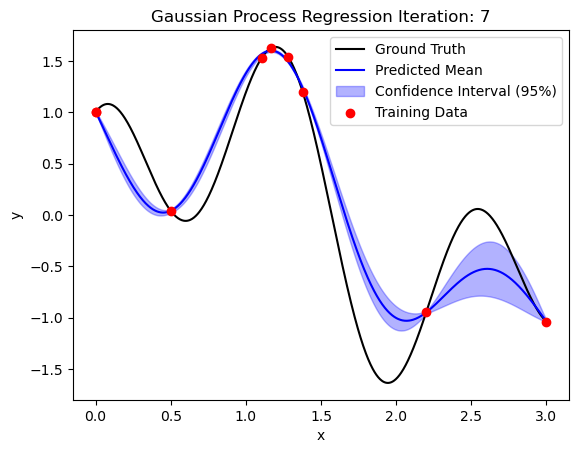

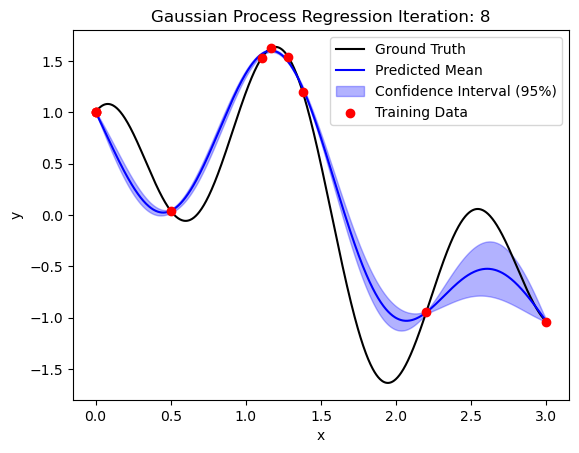

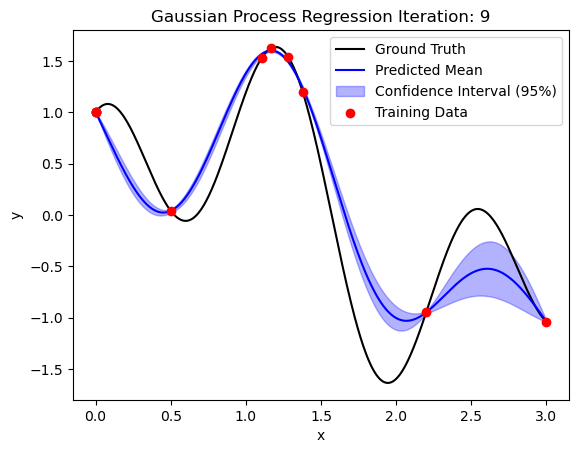

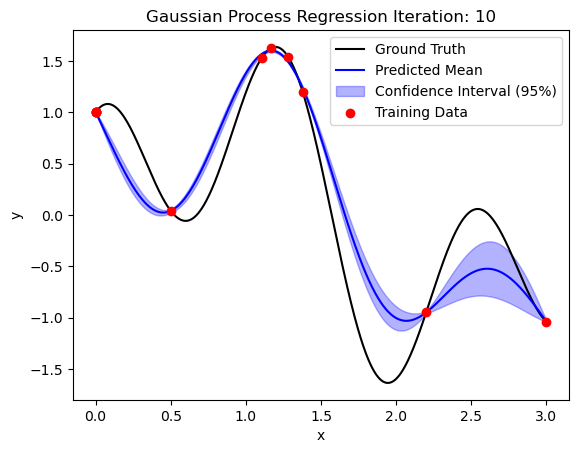

In [ ]:
rand_samples= torch.tensor([.5,2.2])  # Explicitly defining the values

# Known ground truth function values for training (what you've observed)
xaxis = torch.linspace(0, 3, 1000)
ground_truth = torch.sin(2*xaxis) + torch.cos(5*xaxis)

# Let's pretend you only have these observations
train_x = rand_samples
train_y = torch.sin(2*train_x) + torch.cos(5*train_x)  # Ground truth at the observed points

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = torch.tensor(1e-4)

modelpoitest = SurrogateModel(train_x, train_y, likelihood)

bayesian_optimization(modelpoitest,xaxis,train_x,train_y, poi, .0475, 10)

Testing epsilon: 0.010
Epsilon 0.010 - Avg samples to max: 6.09
Testing epsilon: 0.020
Epsilon 0.020 - Avg samples to max: 6.24
Testing epsilon: 0.030
Epsilon 0.030 - Avg samples to max: 6.08
Testing epsilon: 0.040
Epsilon 0.040 - Avg samples to max: 6.35
Testing epsilon: 0.050
Epsilon 0.050 - Avg samples to max: 6.44
Testing epsilon: 0.060
Epsilon 0.060 - Avg samples to max: 6.10
Testing epsilon: 0.070
Epsilon 0.070 - Avg samples to max: 6.34
Testing epsilon: 0.080
Epsilon 0.080 - Avg samples to max: 6.57
Testing epsilon: 0.090
Epsilon 0.090 - Avg samples to max: 6.39
Testing epsilon: 0.100
Epsilon 0.100 - Avg samples to max: 6.37

Optimal epsilon: 0.030
Average samples to reach maximum: 6.08


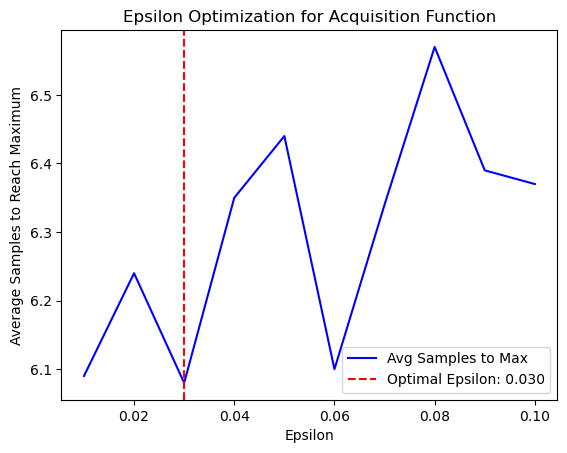

TypeError: cannot unpack non-iterable NoneType object

In [26]:
"""Optimizing UCB"""


# Initialize basic components
xaxis = torch.linspace(0, 3, 1000)
ground_truth = torch.sin(2 * xaxis) + torch.cos(5 * xaxis)

# Test with Expected Improvement (ei)
best_eps, stats = optimize_acquisition(
        acquisition_function=ucb,
        xaxis=xaxis,
        ground_truth=ground_truth,
        n_runs=100,
        epsilon_range=(.01,.1),
        n_epsilons=10,
        n_iter=5,
        tolerance=0.05
    )

In [23]:
"""Optimizing UCB"""


# Initialize basic components
xaxis = torch.linspace(0, 3, 1000)
ground_truth = torch.sin(2 * xaxis) + torch.cos(5 * xaxis)

# Test with Expected Improvement (ei)
best_eps, stats = optimize_acquisition(
        acquisition_function=ucb,
        xaxis=xaxis,
        ground_truth=ground_truth,
        n_runs=100,
        epsilon_range=(.01,.1),
        n_epsilons=10,
        n_iter=5,
        tolerance=0.05
    )

NameError: name 'optimize_acquisition' is not defined

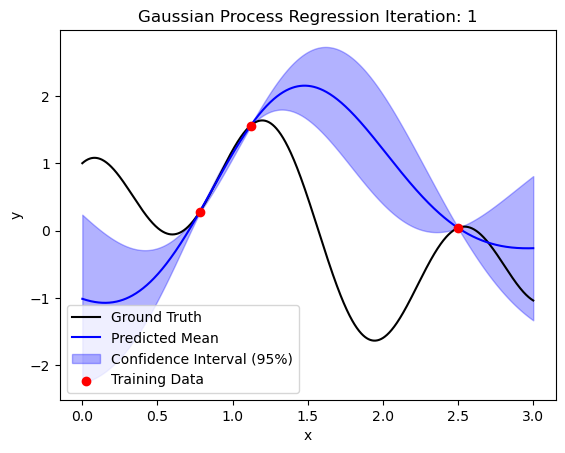

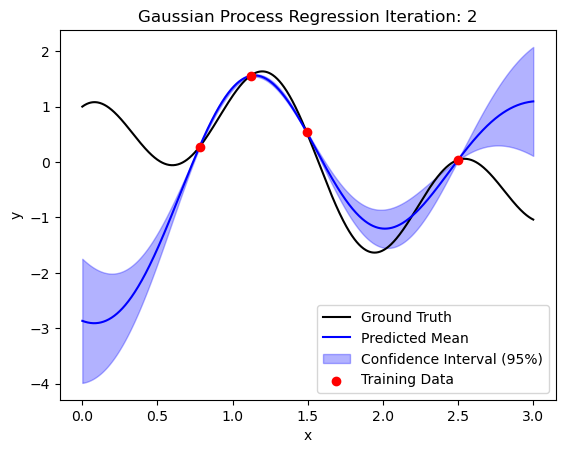

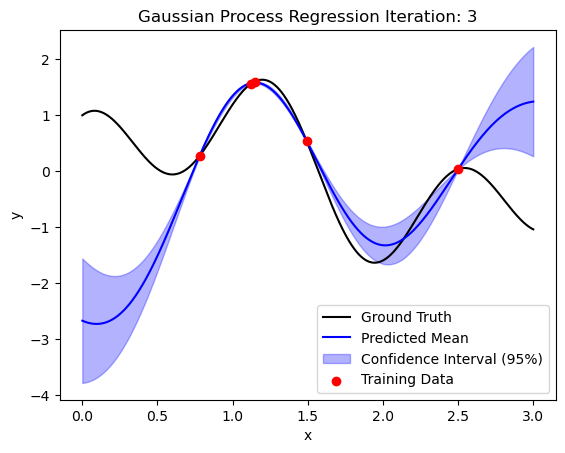

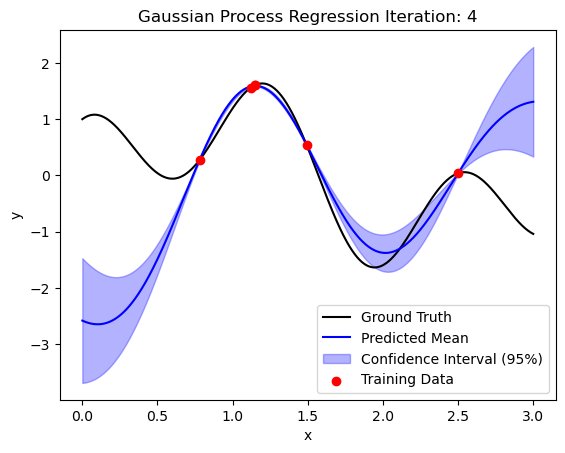

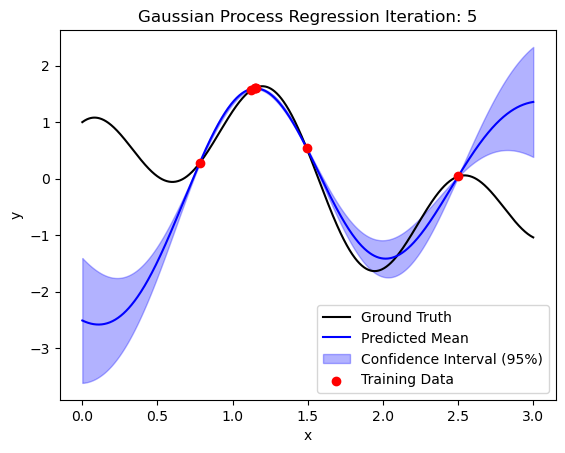

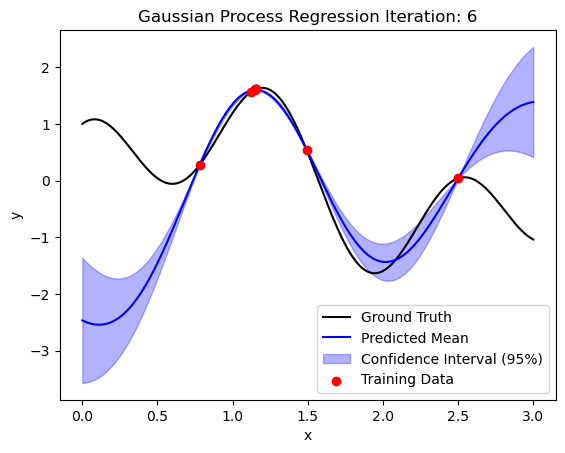

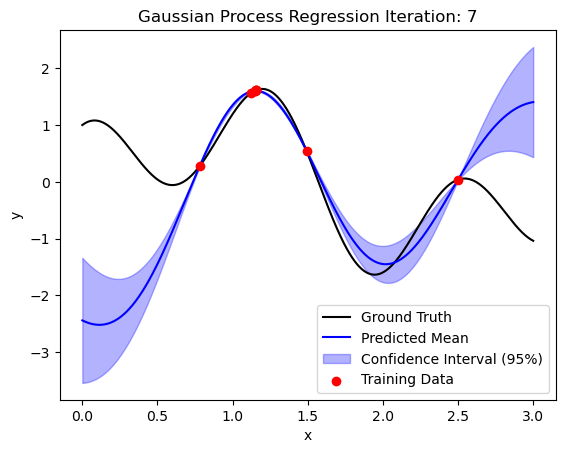

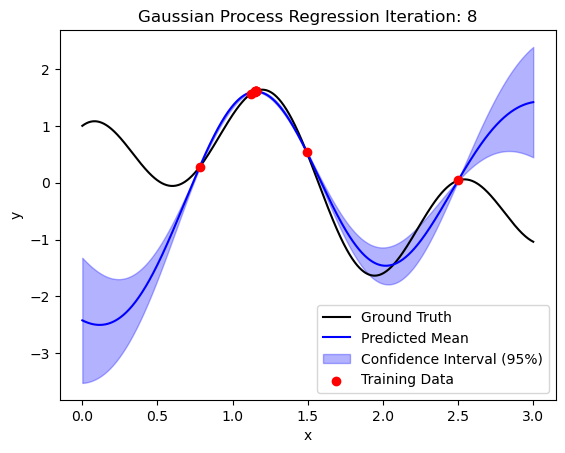

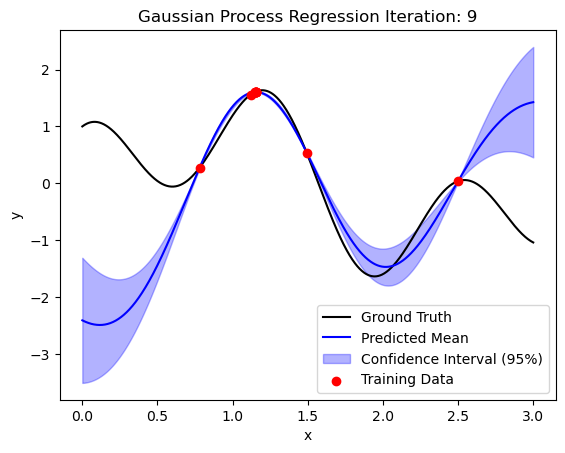

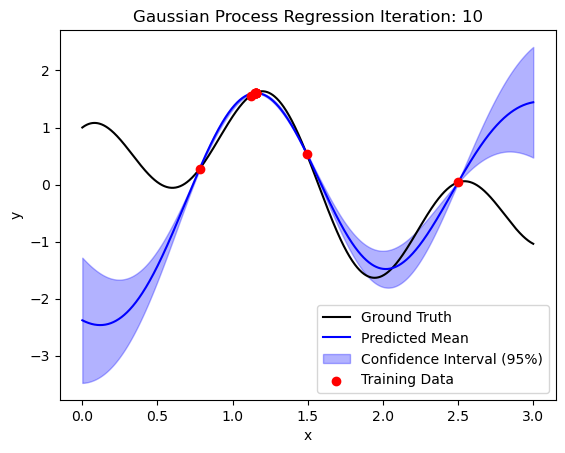

In [ ]:
rand_samples= torch.tensor([.78,2.5])  # Explicitly defining the values

# Known ground truth function values for training (what you've observed)
xaxis = torch.linspace(0, 3, 1000)
ground_truth = torch.sin(2*xaxis) + torch.cos(5*xaxis)

# Let's pretend you only have these observations
train_x = rand_samples
train_y = torch.sin(2*train_x) + torch.cos(5*train_x)  # Ground truth at the observed points

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = torch.tensor(1e-4)

modelucbtest = SurrogateModel(train_x, train_y, likelihood)

bayesian_optimization(modelucbtest,xaxis,train_x,train_y, ucb, .17, 10)

In [ ]:
"""Now we need to use the optimized epsilon values, and run BO on each acquisition 1000 times with randomized initial points"""

'Now we need to use the optimized epsilon values, and run BO on each acquisition 1000 times with randomized initial points'

Running BO 5 times for EI with epsilon=0.058
Running BO 5 times for POI with epsilon=0.048
Running BO 5 times for UCB with epsilon=0.030


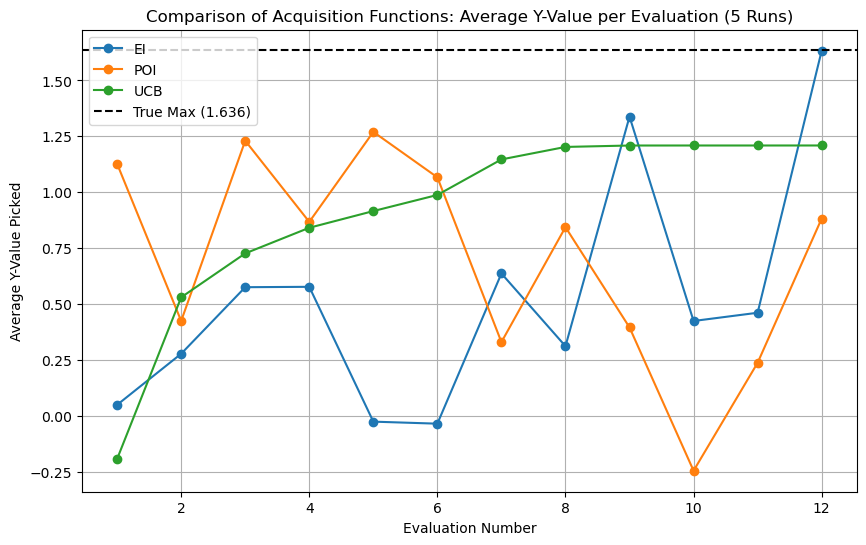

In [61]:
import math
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as dist

# Assuming your SurrogateModel, train (lr=0.1), predict, ei, poi, ucb are defined

def compare_acquisition_functions(acq_functions_with_epsilons, xaxis, ground_truth, n_runs=1000, n_iter=5):
    """
    Compare acquisition functions by averaging y-values picked at each evaluation step.
    
    :param acq_functions_with_epsilons: Dict of {name: (func, epsilon)} pairs.
    :param xaxis: Tensor of input points.
    :param ground_truth: Tensor of true function values.
    :param n_runs: Number of BO runs per function.
    :param n_iter: Number of BO iterations per run.
    :return: Dict of y-values per function.
    """
    results = {}
    for name, (acq_func, epsilon) in acq_functions_with_epsilons.items():
        print(f"Running BO {n_runs} times for {name} with epsilon={epsilon:.3f}")
        y_values = np.zeros((n_runs, n_iter + 2))  # 2 initial + n_iter
        for run in range(n_runs):
            # Random initial points
            rand_samples = torch.rand(2) * 3
            train_x = rand_samples
            train_y = torch.sin(2 * train_x) + torch.cos(5 * train_x)
            
            # Record y-values for initial points
            y_values[run, 0] = train_y[0].item()  # 1st point
            y_values[run, 1] = train_y[1].item()  # 2nd point
            
            # Initialize model
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            likelihood.noise = torch.tensor(1e-4)
            model = SurrogateModel(train_x, train_y, likelihood)
            train(model, train_x, train_y, training_iter=50, lr=0.1)
            
            # BO loop
            for i in range(n_iter):
                next_sample = acq_func(model, xaxis, train_y, epsilon)
                next_y = torch.sin(2 * next_sample) + torch.cos(5 * next_sample)
                train_x = torch.cat([train_x, next_sample.unsqueeze(0)])
                train_y = torch.cat([train_y, next_y.unsqueeze(0)])
                model.set_train_data(train_x, train_y, strict=False)
                train(model, train_x, train_y, training_iter=50, lr=0.1)
                y_values[run, i + 2] = next_y.item()  # Record the y-value picked
        
        results[name] = y_values
    
    # Plotting
    plt.figure(figsize=(10, 6))
    n_evaluations = np.arange(1, n_iter + 2 + 1)  # 1 to 7
    true_max = torch.max(ground_truth).item()
    
    for name, y_values in results.items():
        avg_y_values = np.mean(y_values, axis=0)  # Average y at each step
        plt.plot(n_evaluations, avg_y_values, label=name, marker='o')
    
    plt.axhline(y=true_max, color='k', linestyle='--', label=f'True Max ({true_max:.3f})')
    plt.xlabel('Evaluation Number')
    plt.ylabel('Average Y-Value Picked')
    plt.title(f'Comparison of Acquisition Functions: Average Y-Value per Evaluation ({n_runs} Runs)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return results

# Your execution
if __name__ == "__main__":
    xaxis = torch.linspace(0, 3, 1000)
    ground_truth = torch.sin(2 * xaxis) + torch.cos(5 * xaxis)
    
    optimized_epsilons = {
        'EI': (ei, 0.058),
        'POI': (poi, 0.0475),
        'UCB': (ucb, 0.03)
    }
    
    results = compare_acquisition_functions(
        acq_functions_with_epsilons=optimized_epsilons,
        xaxis=xaxis,
        ground_truth=ground_truth,
        n_runs=5,# From your last run
        n_iter=10
    )
    

Running BO 10 times for EI with epsilon=0.058
Running BO 10 times for POI with epsilon=0.048
Running BO 10 times for UCB with epsilon=0.030


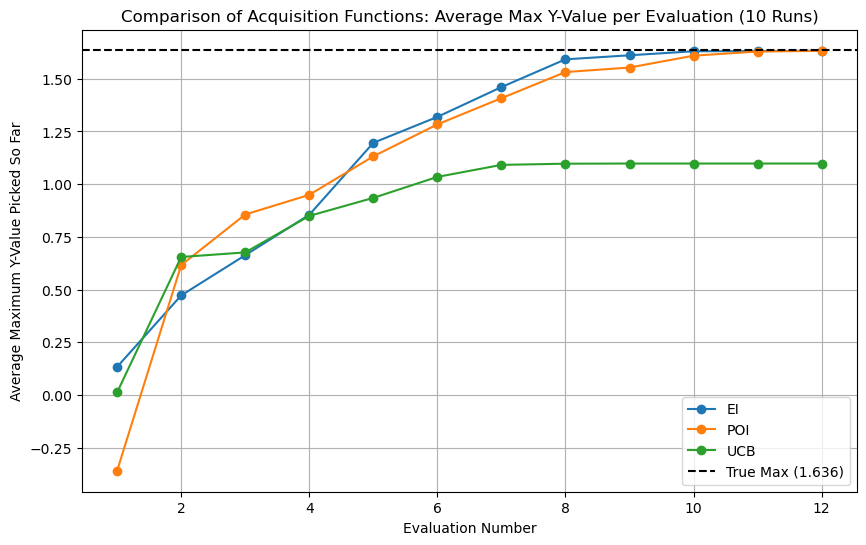

In [64]:
import math
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as dist

# Assuming your SurrogateModel, train (lr=0.1), predict, ei, poi, ucb are defined

def compare_acquisition_functions(acq_functions_with_epsilons, xaxis, ground_truth, n_runs=1000, n_iter=5):
    """
    Compare acquisition functions by averaging the maximum y-values picked up to each evaluation step.
    
    :param acq_functions_with_epsilons: Dict of {name: (func, epsilon)} pairs.
    :param xaxis: Tensor of input points.
    :param ground_truth: Tensor of true function values.
    :param n_runs: Number of BO runs per function.
    :param n_iter: Number of BO iterations per run.
    :return: Dict of y-values per function.
    """
    results = {}
    for name, (acq_func, epsilon) in acq_functions_with_epsilons.items():
        print(f"Running BO {n_runs} times for {name} with epsilon={epsilon:.3f}")
        y_values = np.zeros((n_runs, n_iter + 2))  # 2 initial + n_iter
        max_y_values = np.zeros((n_runs, n_iter + 2))  # To track max y so far
        for run in range(n_runs):
            # Random initial points
            rand_samples = torch.rand(2) * 3
            train_x = rand_samples
            train_y = torch.sin(2 * train_x) + torch.cos(5 * train_x)
            
            # Record y-values for initial points
            y_values[run, 0] = train_y[0].item()  # 1st point
            y_values[run, 1] = train_y[1].item()  # 2nd point
            max_y_values[run, 0] = y_values[run, 0]
            max_y_values[run, 1] = max(y_values[run, 0], y_values[run, 1])
            
            # Initialize model
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            likelihood.noise = torch.tensor(1e-4)
            model = SurrogateModel(train_x, train_y, likelihood)
            train(model, train_x, train_y, training_iter=50, lr=0.1)
            
            # BO loop
            for i in range(n_iter):
                next_sample = acq_func(model, xaxis, train_y, epsilon)
                next_y = torch.sin(2 * next_sample) + torch.cos(5 * next_sample)
                train_x = torch.cat([train_x, next_sample.unsqueeze(0)])
                train_y = torch.cat([train_y, next_y.unsqueeze(0)])
                model.set_train_data(train_x, train_y, strict=False)
                train(model, train_x, train_y, training_iter=50, lr=0.1)
                y_values[run, i + 2] = next_y.item()  # Record the y-value picked
                # Update max y so far
                max_y_values[run, i + 2] = max(max_y_values[run, i + 1], y_values[run, i + 2])
        
        results[name] = max_y_values  # Store the max y values instead of raw y values
    
    # Plotting
    plt.figure(figsize=(10, 6))
    n_evaluations = np.arange(1, n_iter + 2 + 1)  # 1 to 7
    true_max = torch.max(ground_truth).item()
    
    for name, max_y_values in results.items():
        avg_max_y_values = np.mean(max_y_values, axis=0)  # Average max y at each step
        plt.plot(n_evaluations, avg_max_y_values, label=name, marker='o')
    
    plt.axhline(y=true_max, color='k', linestyle='--', label=f'True Max ({true_max:.3f})')
    plt.xlabel('Evaluation Number')
    plt.ylabel('Average Maximum Y-Value Picked So Far')
    plt.title(f'Comparison of Acquisition Functions: Average Max Y-Value per Evaluation ({n_runs} Runs)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return results

# Your execution
if __name__ == "__main__":
    xaxis = torch.linspace(0, 3, 1000)
    ground_truth = torch.sin(2 * xaxis) + torch.cos(5 * xaxis)
    
    optimized_epsilons = {
        'EI': (ei, 0.058),
        'POI': (poi, 0.0475),
        'UCB': (ucb, 0.03)
    }
    
    results = compare_acquisition_functions(
        acq_functions_with_epsilons=optimized_epsilons,
        xaxis=xaxis,
        ground_truth=ground_truth,
        n_runs=10,  # From your last run
        n_iter=10
    )

In [59]:
# Your known samples (measured values)

rand_samples = torch.rand(2) * 3  # Two random points in [0, 3] # Explicitly defining the values

# Known ground truth function values for training (what you've observed)
xaxis = torch.linspace(0, 3, 1000)
ground_truth = torch.sin(2*xaxis) + torch.cos(5*xaxis)

# Let's pretend you only have these observations
train_x = rand_samples
train_y = torch.sin(2*train_x) + torch.cos(5*train_x)  # Ground truth at the observed points

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = torch.tensor(1e-4)

modell = SurrogateModel(train_x,train_y,likelihood)